# Create an input data set of $a_0$ and $\rho(z)$ for the vKdV model

In [2]:
import h5py
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid.inset_locator import inset_axes
#from mpl_toolkits.axisartist.
from matplotlib.collections import LineCollection

from glob import glob

/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/mpl_toolkits/axes_grid/__init__.py:12: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  obj_type='module')


In [3]:
#%matplotlib notebook

In [4]:
plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'axes.labelsize':'large'})

In [5]:
def double_tanh_6(beta, z):
    
    return beta[0,...] - beta[1,...]*(np.tanh((z+beta[2,...])/beta[3,...])
                + np.tanh((z+beta[2,...] + beta[4,...])/beta[5,...]))

In [6]:
def maximum_amplitude_finder(amp_signal):
    amp_min = np.min(amp_signal)
    amp_max = np.max(amp_signal)
    if np.abs(amp_min)>amp_max:
        return amp_min, np.argwhere(amp_signal==amp_min)[0][0]
    else:
        return amp_max, np.argwhere(amp_signal==amp_max)[0][0]

In [7]:
def load_density_h5(h5file):
    f = h5py.File(h5file,'r')
    rho = f['rho'][:]
    depth = f['depth'][:]
    data = f['beta_samples'][:]
    time = f['time'][:].astype('<M8[ns]')
    f.close()
    return data,time, rho, depth

def load_density_xr(h5file):
    data,time, rho, depth = load_density_h5(h5file)

    nparams, nt, ntrace = data.shape
    dims3 = ('params','time','ensemble')

    coords3 = {'time':time, 'ensemble':range(ntrace), 'params':range(nparams)}



    beta_da = xr.DataArray(data,
        coords=coords3,
        dims=dims3,
        attrs={'long_name':'', 'units':''},
        )

    return xr.Dataset({'beta':beta_da,})

In [13]:
###########
# Inputs
#datadir = '/home/suntans/cloudstor/Data/IMOS/'
datadir = '../../run_ddcurves/DATA_SHELL/'

# ddcurves BHM output file
nparams=6
#h5file = '%s/Crux_KP150_12mth_Density_lowpass_density_bhm_6params_2018-12-16.h5'%datadir
h5file = '%s/Crux_KP150_Phs2_Density_lowpass_density_bhm_6params_2018-11-23.h5'%datadir

density_func = double_tanh_6


In [33]:
# Load the output of ddcurves as an xarray object
ds = load_density_xr(h5file)
ds

<xarray.Dataset>
Dimensions:   (ensemble: 500, params: 6, time: 750)
Coordinates:
  * time      (time) datetime64[ns] 2016-10-31T06:40:00 ... 2017-05-06T12:40:00
  * ensemble  (ensemble) int64 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * params    (params) int64 0 1 2 3 4 5
Data variables:
    beta      (params, time, ensemble) float64 1.023e+03 1.023e+03 ... 30.12

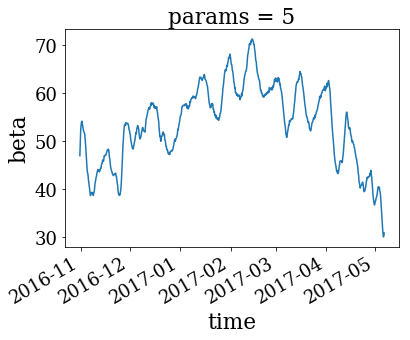

In [39]:
plt.figure()
ds.beta[5,:,:].median(axis=-1).plot()

In [15]:
# Load the amplitude and density data

ncfile = '/home/suntans/Share/ARCHub/DATA/FIELD/ShellCrux/KP150_Fitted_Buoyancy_wout_motion.nc'

ds1 = xr.open_dataset(ncfile,group='KP150_phs1')
ds2 = xr.open_dataset(ncfile,group='KP150_phs2')

# Merge the two
A_n = xr.concat([ds1['A_n'][:,0],ds2['A_n'][:,0]], dim='time')

In [17]:
# Create a time series of single days with the max amplitude and a guess at beta
time1 = pd.date_range('2016-5-1','2016-9-15') 
time2 = pd.date_range('2016-11-1','2017-5-1')

#time = time1.append(time2)
time = time2
time

DatetimeIndex(['2016-11-01', '2016-11-02', '2016-11-03', '2016-11-04',
               '2016-11-05', '2016-11-06', '2016-11-07', '2016-11-08',
               '2016-11-09', '2016-11-10',
               ...
               '2017-04-22', '2017-04-23', '2017-04-24', '2017-04-25',
               '2017-04-26', '2017-04-27', '2017-04-28', '2017-04-29',
               '2017-04-30', '2017-05-01'],
              dtype='datetime64[ns]', length=182, freq='D')

In [31]:
print('time, timemax, Amax, beta0, beta1, beta2, beta3, beta4, beta5')
for t1,t2 in zip(time[0:-1],time[1::]):
    A = A_n.sel(time=slice(t1,t2))
    
    # Find the amplitude
    Amax,idx = maximum_amplitude_finder(A.values)
    
    #plt.figure()
    #A.plot()
    #plt.plot(A.time.values[idx],Amax,'mo')
    
    # Find a representative (median) beta
    dsc=ds.sel(time=t2,method='nearest')
    meanbeta = dsc.beta.median(axis=-1).values
    #print('{}, {}, {}'.format(t1, A.time.values[idx], Amax, ))
    outstr = '%s, %s, %3.2f'%(t1, A.time.values[idx], Amax, )
    for bb in meanbeta:
        outstr +=', %3.2f'%bb

    print(outstr)
    #print('{}, {}, {}, {}, {}, {}, {}, {}, {}'.format(t1, A.time.values[idx], Amax, dsc.beta.mean(axis=-1).values) )
    



time, timemax, Amax, beta0, beta1, beta2, beta3, beta4, beta5
2016-11-01 00:00:00, 2016-11-01T05:47:00.000000000, -22.35, 1023.26, 1.25, 62.85, 62.25, 91.05, 53.20
2016-11-02 00:00:00, 2016-11-02T17:53:00.000000000, -24.94, 1023.26, 1.25, 62.65, 63.83, 90.50, 51.77
2016-11-03 00:00:00, 2016-11-03T12:05:00.000000000, 27.27, 1023.26, 1.25, 62.71, 64.90, 91.79, 47.92
2016-11-04 00:00:00, 2016-11-04T18:24:00.000000000, -26.74, 1023.26, 1.25, 62.77, 66.03, 93.24, 43.40
2016-11-05 00:00:00, 2016-11-05T06:20:00.000000000, -24.84, 1023.25, 1.25, 62.83, 65.73, 94.28, 40.82
2016-11-06 00:00:00, 2016-11-06T19:21:00.000000000, -20.59, 1023.25, 1.25, 63.07, 64.66, 94.49, 39.08
2016-11-07 00:00:00, 2016-11-07T19:53:00.000000000, -22.32, 1023.24, 1.25, 63.33, 62.98, 95.36, 39.32
2016-11-08 00:00:00, 2016-11-08T08:45:00.000000000, -20.83, 1023.24, 1.25, 63.27, 60.26, 94.53, 39.53
2016-11-09 00:00:00, 2016-11-09T19:47:00.000000000, -17.62, 1023.26, 1.25, 63.34, 60.93, 92.46, 41.97
2016-11-10 00:00:00, 

2017-01-22 00:00:00, 2017-01-22T15:04:00.000000000, 13.83, 1023.37, 1.24, 62.35, 69.55, 91.15, 54.85
2017-01-23 00:00:00, 2017-01-23T09:03:00.000000000, -13.31, 1023.37, 1.25, 62.40, 67.79, 89.04, 54.63
2017-01-24 00:00:00, 2017-01-24T11:02:00.000000000, -15.23, 1023.41, 1.25, 62.44, 62.43, 86.72, 54.92
2017-01-25 00:00:00, 2017-01-25T19:55:00.000000000, 13.80, 1023.45, 1.25, 62.35, 60.97, 86.98, 56.30
2017-01-26 00:00:00, 2017-01-26T09:42:00.000000000, 18.64, 1023.44, 1.25, 62.33, 64.11, 88.38, 59.85
2017-01-27 00:00:00, 2017-01-27T21:46:00.000000000, 16.98, 1023.43, 1.24, 61.94, 67.64, 89.31, 63.21
2017-01-28 00:00:00, 2017-01-28T16:38:00.000000000, -18.99, 1023.42, 1.24, 61.80, 70.14, 89.38, 64.66
2017-01-29 00:00:00, 2017-01-29T11:07:00.000000000, 17.99, 1023.44, 1.24, 61.63, 71.07, 89.94, 65.72
2017-01-30 00:00:00, 2017-01-30T06:18:00.000000000, -18.69, 1023.47, 1.24, 61.97, 71.13, 91.10, 67.49
2017-01-31 00:00:00, 2017-01-31T13:22:00.000000000, 21.34, 1023.47, 1.24, 61.84, 70.02,

2017-04-16 00:00:00, 2017-04-16T07:42:00.000000000, -29.55, 1023.41, 1.25, 62.37, 62.41, 91.52, 50.13
2017-04-17 00:00:00, 2017-04-17T06:40:00.000000000, -27.77, 1023.37, 1.25, 62.80, 62.28, 92.51, 48.75
2017-04-18 00:00:00, 2017-04-18T08:12:00.000000000, -38.53, 1023.34, 1.25, 63.04, 63.49, 93.77, 47.04
2017-04-19 00:00:00, 2017-04-19T08:22:00.000000000, -25.29, 1023.35, 1.25, 63.08, 62.42, 93.53, 45.19
2017-04-20 00:00:00, 2017-04-20T09:00:00.000000000, -21.52, 1023.37, 1.25, 62.80, 62.16, 93.57, 41.60
2017-04-21 00:00:00, 2017-04-21T01:08:00.000000000, 16.83, 1023.37, 1.25, 62.73, 63.65, 94.49, 40.62
2017-04-22 00:00:00, 2017-04-22T11:56:00.000000000, -14.08, 1023.38, 1.25, 62.47, 62.10, 94.10, 41.45
2017-04-23 00:00:00, 2017-04-23T19:32:00.000000000, 17.42, 1023.38, 1.25, 62.20, 60.11, 92.21, 39.56
2017-04-24 00:00:00, 2017-04-24T20:37:00.000000000, 17.53, 1023.39, 1.25, 62.11, 60.17, 91.87, 40.42
2017-04-25 00:00:00, 2017-04-25T14:40:00.000000000, -20.21, 1023.39, 1.25, 61.96, 61.